In [2]:
import os.path

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [3]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [4]:
dataset = 'cifar10'
proxy = 'nwot'
data = dfs[dataset]

In [5]:
bench_dir = os.path.join(naslib_path, f'naslib/data/zc_benchmarks/{proxy}')
new_scores = [p for p in os.listdir(bench_dir) if 'nasbench201' in p and 'norm' in p]
new_scores

['benchmark--normalize--no_relu--nasbench201--cifar10--0.json',
 'benchmark--normalize--relu--nasbench201--cifar10--0.json',
 'benchmark--no_norm--relu--nasbench201--cifar10--0.json']

In [6]:
import json
import os

new_score_file = new_scores[1]
print(new_score_file)

with open(os.path.join(bench_dir, new_score_file), 'r') as f:
    new_data = json.load(f)

benchmark--normalize--relu--nasbench201--cifar10--0.json


In [7]:
from zc_combine.fixes.utils import read_new_score

read_new_score(data, new_data, proxy, copy_old_column=False)

In [8]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_default_isomorphic_cell

op_names, edge_map = get_ops_edges_nb201()
nb201_default_isomorphic_cell(data, edge_map)

In [9]:
import numpy as np
from zc_combine.fixes.utils import aggregate_isomorphic_scores

valid_data = data[data['val_accs'] > 30]
unique_data = aggregate_isomorphic_scores(valid_data, ['new_nwot'], agg_func=np.median, score_std=3)

In [10]:
unique_data

,net,val_accs,val_accs_std,new_nwot,new_nwot_std
0,"(4, 0, 3, 1, 4, 3)",84.99,NaN,-63.365379,NaN
1,"(2, 4, 0, 0, 3, 2)",90.52,NaN,-51.566022,NaN
2,"(2, 1, 3, 1, 4, 1)",88.01,0.263595,-49.329956,1.499236
3,"(0, 0, 2, 1, 2, 3)",88.32,NaN,-48.078427,NaN
4,"(2, 1, 0, 1, 3, 1)",90.16,0.266109,-48.821607,0.683132
...,...,...,...,...,...
9439,"(3, 2, 4, 0, 4, 0)",88.09,NaN,-59.218529,NaN
9440,"(4, 2, 1, 4, 3, 0)",85.59,NaN,-59.368927,NaN
9441,"(2, 3, 3, 3, 2, 4)",89.46,NaN,-47.472823,NaN
9442,"(3, 1, 4, 2, 0, 4)",86.27,NaN,-54.471894,NaN


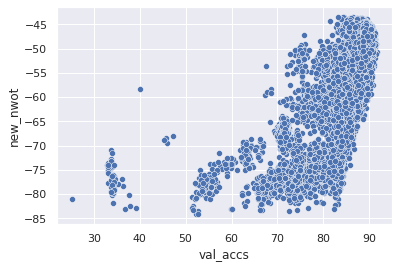

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_data = data[data['new_nwot'] > -1e8].copy()

sns.scatterplot(data=plot_data, x='val_accs', y='new_nwot')
#plt.xlim(70, 91)
#plt_ylim(proxy)
plt.show()

In [12]:
from zc_combine.fixes.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3, 4}
ops = parse_ops_nb201(plot_data)
count_all_ops(plot_data, ops, count_set)

In [13]:
# NB201 op names and edge indices to edges for convenience
OP_NAMES = ["Identity", "Zero", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['skip_connect', 'none', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

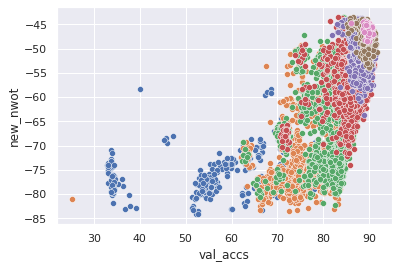

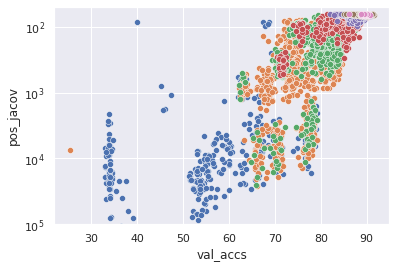

In [14]:
from zc_combine.fixes.operations import plot_clouds

vmax = 7
plot_clouds(plot_data, (2,3), 'new_nwot', vmax=vmax)
plt.show()

plot_data['pos_jacov'] = -plot_data['jacov']
plot_clouds(plot_data, (2,3), 'pos_jacov', vmax=vmax)

plt.yscale('log')
plt.ylim(1e5, 5 * 1e1)
plt.show()

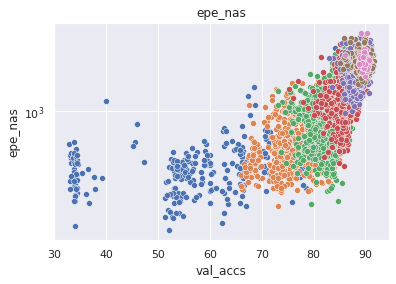

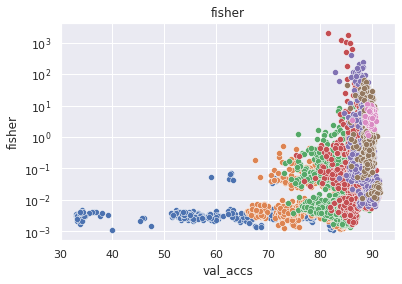

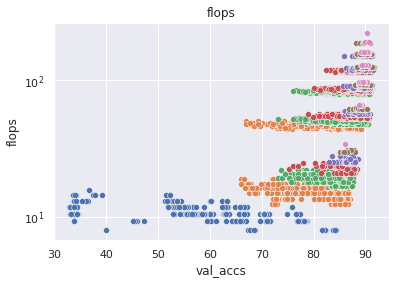

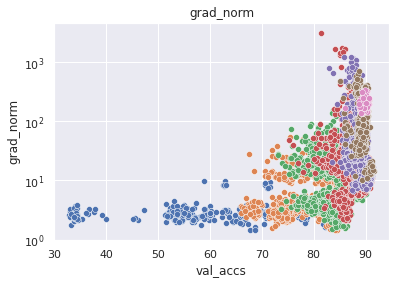

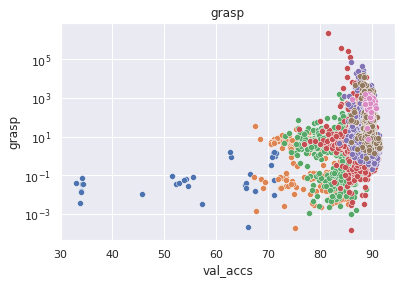

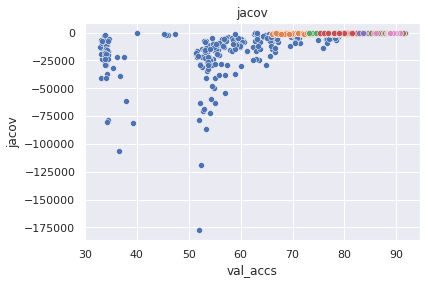

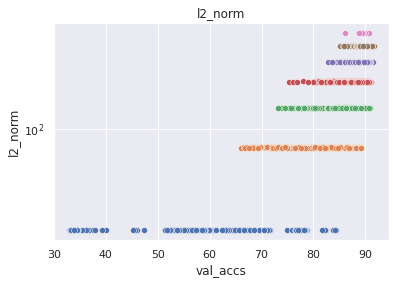

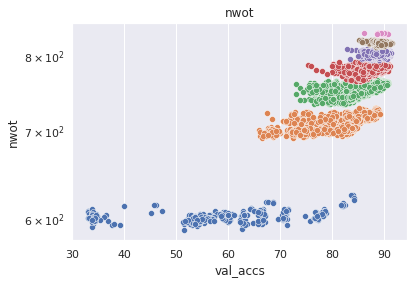

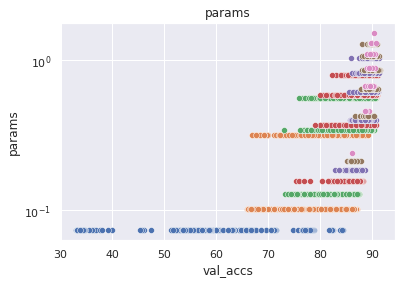

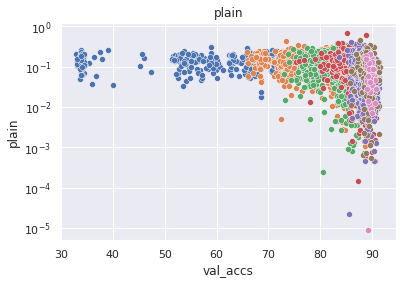

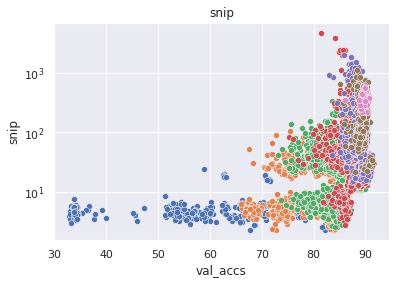

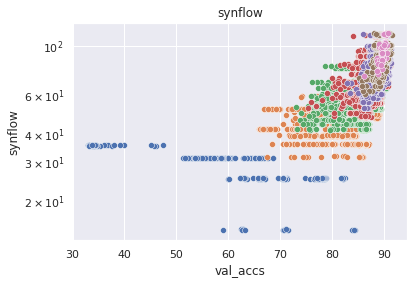

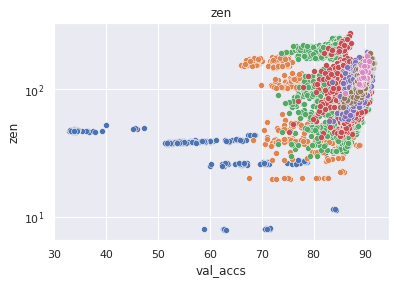

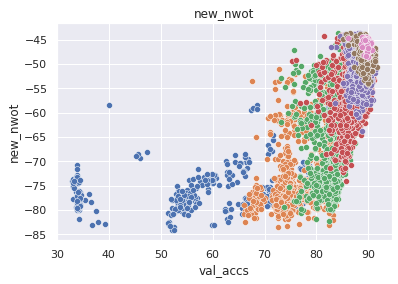

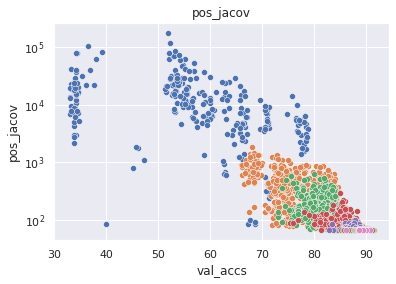

In [15]:
uniq_plot_data = plot_data[plot_data['net'] == plot_data['new_net']]

for p in uniq_plot_data.columns:
    if p in ['new_net', 'net', 'val_accs', 'rank', 'random'] or '(' in p:
        continue

    d = uniq_plot_data[uniq_plot_data[p] > -1e8]
    d = d[d['net'] == d['new_net']]

    plot_clouds(d, (2, 3), p, vmax=7)
    plt.title(p)
    if any(d[p] > 0):
        plt.yscale('log')
    #plt.ylim(-32.8, -31.8)
    #plt.xlim(40, 45)
    #plt.ylim(680, 695)
    #plt.savefig(f"{p}_{dataset}_log.png")
    plt.show()

In [16]:
from zc_combine.fixes.operations import filter_by_range


dd = filter_by_range(uniq_plot_data, 'val_accs', 70, 82).copy()
dd = filter_by_range(dd, 'fisher', 1e-2, 1)
dd['log_fisher'] = np.log(dd['fisher'])

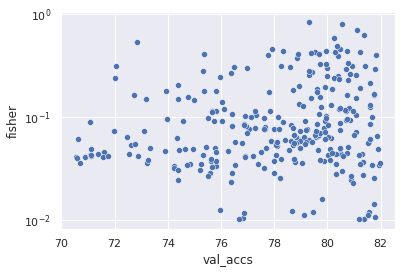

In [79]:
sns.scatterplot(data=dd, x='val_accs', y='fisher')
plt.yscale('log')
plt.show()

In [81]:
dd

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,...,"(1, 3, 4)","(2, 3, 4)","(0, 1, 2, 3)","(0, 1, 2, 4)","(0, 1, 3, 4)","(0, 2, 3, 4)","(1, 2, 3, 4)","(0, 1, 2, 3, 4)",pos_jacov,log_fisher
180,"(4, 3, 1, 3, 4, 4)",77.88,971.802774,0.057796,20.539072,13.859978,5.404241,-121.452984,129.835907,752.947136,...,6,5,3,4,6,5,6,6,121.452984,-2.850828
182,"(4, 0, 4, 4, 3, 3)",81.26,948.783191,0.035136,20.539072,11.785982,1.689774,-118.863753,129.392136,756.123513,...,5,5,3,4,6,6,5,6,118.863753,-3.348519
278,"(4, 4, 4, 1, 2, 2)",80.06,971.020866,0.063495,83.453632,19.841358,5.693802,-156.456487,129.652008,754.576593,...,4,5,3,6,4,5,6,6,156.456487,-2.756791
291,"(4, 4, 1, 1, 2, 4)",77.86,1093.715207,0.114299,47.634112,20.418505,18.317753,-140.867155,78.956535,715.872417,...,5,4,3,6,5,4,6,6,140.867155,-2.168938
309,"(4, 1, 1, 3, 2, 4)",80.41,1181.666861,0.385692,50.706112,41.656147,-5.132553,-109.379318,129.810028,759.850954,...,5,4,4,5,5,4,6,6,109.379318,-0.952717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15379,"(4, 4, 1, 1, 2, 2)",78.33,1227.387703,0.433525,82.163392,56.742065,2.781822,-107.345198,129.798752,759.610267,...,4,4,4,6,4,4,6,6,107.345198,-0.835807
15399,"(3, 4, 4, 4, 4, 3)",80.60,1079.188471,0.041143,21.829312,15.571813,8.113127,-97.337416,130.063919,751.057423,...,6,6,2,4,6,6,6,6,97.337416,-3.190704
15441,"(4, 1, 1, 2, 4, 0)",77.63,959.417722,0.075459,46.343872,17.465094,1.401936,-157.239103,78.621613,712.621650,...,4,3,4,6,5,4,5,6,157.239103,-2.584172
15446,"(4, 4, 1, 4, 4, 2)",73.98,787.367488,0.094321,48.924352,25.095221,12.789936,-242.925236,78.645912,708.375002,...,5,5,2,6,5,5,6,6,242.925236,-2.361051
